# Code

In [1]:
import os
import h5py
from PIL import Image
import operator

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

import tensorflow.keras
from PIL import Image
import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D ,Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Input
from keras.applications import VGG16
from keras import backend
from keras import optimizers
from tensorflow.keras import applications
from keras.utils.conv_utils import convert_kernel


%matplotlib inline

/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rtcl/Deep-fashion/D

In [2]:
import tensorflow as tf
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

In [3]:
class_pattern = {
    0: 'Checked',
    1: 'Floral',
    2: 'Graphic',
    3: 'Plain',
    4: 'Striped'}
class_fabric = {
    0: 'Chiffon',
    1: 'Cotton',
    2: 'Crochet',
    3: 'Denim',
    4: 'Wool'}
class_color = {
    0: 'Black',
    1: 'Blue',
    2: 'Green',
    3: 'Red',
    4: 'White'}
class_style = {
    0: 'Casual',
    1: 'Formal',
    2: 'Party',
    3: 'Sports',
    4: 'Vacance'}

In [4]:
def show_sample(X):
    im = X
    plt.imshow(im)
    
    plt.axis('on')
    plt.show()

In [5]:
img_width, img_height = 150, 150

imagelist = []
# top_model_weights_path = 'bottleneck_fc_model.h5'
image_data_dir = 'retail_shops'
#chosenOnes = sorted(os.listdir(train_data_dir))
count = 0

test_datagen = ImageDataGenerator(rescale=1./255)

data1_generator = test_datagen.flow_from_directory(
        image_data_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode=None,
        shuffle = False)

Found 23 images belonging to 1 classes.


In [6]:
# Reshaping the images array
nb_data_samples = 23
c=0
images_valid=[]
for X_batch in data1_generator:
    c+=1
    if (c>nb_data_samples):
        break
    images_valid.append(X_batch[0,:,:,:])
    

data_images=np.asarray(images_valid)
print (data_images.shape)

(23, 150, 150, 3)


In [7]:
image_input_dir = 'find_identical_output/'
test_datagen = ImageDataGenerator(rescale=1./255)
inpdata_generator = test_datagen.flow_from_directory(
        image_input_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode=None,
        shuffle = False)

Found 1 images belonging to 1 classes.


In [8]:
nb_input_samples = 1
c=0
images_input=[]
for X_batch in inpdata_generator:
    c+=1
    if (c>nb_input_samples):
        break
    images_input.append(X_batch[0,:,:,:])
    

data_images_inp=np.asarray(images_input)
print (data_images_inp.shape)

(1, 150, 150, 3)


In [9]:
pattern_model = load_model('./models/vgg_weights_best_pattern.hdf5')
fabric_model = load_model('./models/vgg_weights_best_fabric.hdf5')
color_model = load_model('./models/vgg_weights_best_color.hdf5')
style_model = load_model('./models/vgg_weights_best_style.hdf5')
# part_model = load_model('./models/vgg_weights_best_part.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [10]:
inp_pattern=pattern_model.predict(data_images_inp)
inp_fabric=fabric_model.predict(data_images_inp)
inp_color=color_model.predict(data_images_inp)
inp_style=style_model.predict(data_images_inp)
# part=part_model.predict(data_images_inp)
print ("Pattern : " , inp_pattern.shape)
print ("fabric : " , inp_fabric.shape)
print ("color : " , inp_color.shape)
print ("Style : " , inp_style.shape) 
# print ("Part : " , inp_part.shape)

Pattern :  (1, 5)
fabric :  (1, 5)
color :  (1, 5)
Style :  (1, 5)


In [12]:
for i in range(len(data_images_inp)):
    print ("Pattern : ", class_pattern[np.argmax(inp_pattern[i])])
    print ("Fabric : ", class_fabric[np.argmax(inp_fabric[i])])
    print ("Color : ", class_color[np.argmax(inp_color[i])])
    print ("Style : ", class_style[np.argmax(inp_style[i])])

Pattern :  Plain
Fabric :  Cotton
Color :  Black
Style :  Formal


In [13]:
inp_feature_list=[]
for i in range(len(data_images_inp)):
    vals=np.zeros(4)
    vals[0] = np.argmax(inp_pattern[i])
    vals[1] = np.argmax(inp_fabric[i])
    vals[2] = np.argmax(inp_color[i])
    vals[3] = np.argmax(inp_style[i])
#     vals[4] = np.argmax(inp_part[i])
    inp_feature_list.append(vals)
    
inp_feature_data = np.asarray(inp_feature_list)
print (inp_feature_data.shape)

(1, 4)


In [14]:
def similarity(feature_data,inp_feature_data):
    num_samp=inp_feature_data.size
#     print (num_samp)
    sim_score={}
    for i in range(len(feature_data)):
        score=0
#         show_sample(data_images[i])
#         print(feature_data[i])
        score_m= inp_feature_data - feature_data[i]
#         print (score_m)
        score = num_samp-np.count_nonzero(score_m)
        sim_score[i]=score
#         print (score)
    
    return sim_score

Score :  4


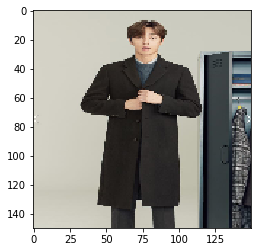

Score :  3


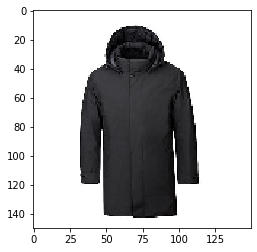

Score :  3


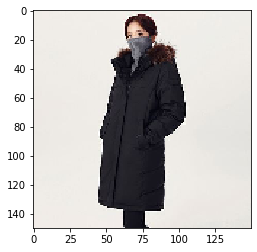

Score :  3


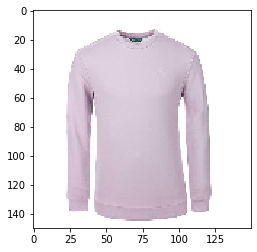

Score :  3


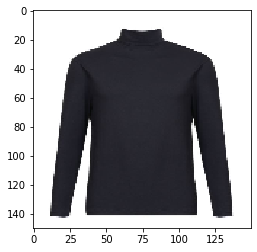

In [15]:
feature_data=np.load('db_features.npy')
similarities=similarity(feature_data,inp_feature_data)
sorted_similarities = sorted(similarities.items(), key=operator.itemgetter(1),reverse=True)
# print (sorted_similarities)
num_reco=5
num_data=feature_data.size
for i in range(num_reco):
    ind = sorted_similarities[i][0]
    print("Score : ", sorted_similarities[i][1])
    show_sample(data_images[ind])